# MgO Analysis Iris

We start with manual scans from MgO 1800 nm short pulses

In [1]:
from context import Harmonics_Analysis
from Harmonics_Analysis.scan_anal import Scan
from Harmonics_Analysis.iris_functions import Iris
import os
from scipy.optimize import curve_fit
import numpy as np 
import matplotlib.pyplot as plt
from functions import Andor_calib
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Iris calibration from 28th Jan at 1800 nm short pulse
""" 1800 nm scans"""
power_2801_1800short = np.array([184, 180, 180,180,180,180,176, 180,180,165,162,150,130,110,86,58,31,11.5,4])*1e-3
iris_pos_2801_1800short = np.linspace(45,-45,19)

iris_2801 = Iris()
iris_2801.specify_calib(iris_positions=iris_pos_2801_1800short, powers=power_2801_1800short)
iris_2801.specify_params(w0_init=100e-6, f=0.75, wl=1800e-9, M2=1, reprate=1000,pulse_duration=15e-15)


In [3]:
data_folder = '../../../Data/' 
os.listdir(data_folder+'2022-01-28')

['LowInt_SampleX-10_Y-5.25_Z9.0_rot_2_MgO_SWIR',
 '.DS_Store',
 'HCF_spectra.ocv',
 'HCF_spectra_685mWin_240mWout.ocv',
 'Iris_scan_SampleX-10_Y-5.25_Z9.0_rot_2_MgO_SWIR_MCP1200V_scanningUp_MCPpos100',
 'SWIR_first_glimpse_of_harmonics_70000.sif',
 'SWIR_Spe.txt',
 'SWIR_I-24_P90mW_MCPpos70000_MCPV-1200_expo30s.tif',
 'SWIR_I-24_P90mW_MCPpos70000_MCPV-1200_expo30s.sif',
 'Iris_scan_SampleX-10_Y-5.25_Z9.0_rot_2_MgO_SWIR_MCP1200V_scanningUp_MCPpos70',
 'Iris_scan_SampleX-10_Y-5.25_Z6.8_rot_2_MgO_SWIRMCP1200V_scanningDown_MCPpos70']

# Iris Scan Analysis

Manual Scans but this is the data we have from the MgO

'Iris_scan_SampleX-10_Y-5.25_Z9.0_rot_2_MgO_SWIR_MCP1200V_scanningUp_MCPpos100'

## MCP 100 Up 

In [4]:
MCP100_Up_Iris_Folder = os.path.join(data_folder, '2022-01-28/','Iris_scan_SampleX-10_Y-5.25_Z9.0_rot_2_MgO_SWIR_MCP1200V_scanningUp_MCPpos100')
MCP70_Up_Iris_Folder = os.path.join(data_folder, '2022-01-28/Iris_scan_SampleX-10_Y-5.25_Z9.0_rot_2_MgO_SWIR_MCP1200V_scanningUp_MCPpos70')
MCP70_Down_Iris_Folder =  os.path.join(data_folder, '2022-01-28/Iris_scan_SampleX-10_Y-5.25_Z6.8_rot_2_MgO_SWIRMCP1200V_scanningDown_MCPpos70')
Low_Iris = os.path.join(data_folder, '2022-01-28', 'LowInt_SampleX-10_Y-5.25_Z9.0_rot_2_MgO_SWIR')

In [5]:
MCP100_Iris = Scan()
MCP100_Iris.set_folder(MCP100_Up_Iris_Folder)
MCP100_Iris.set_verlim(100, 300)
files = [i for i in os.listdir(MCP100_Up_Iris_Folder)]
bg = ['-45_repeat2.tif','-45_repeat.tif']
exclude = bg+['-28.5.tif','-22_repeat.tif','-28.5_repeat.tif', '-28.5_repeat2.tif','-24.5_repeat.tif','-22_mightbe22.5.tif' ]
files = [i for i in files if i not in exclude]
variables = [float(i[:-4]) for i in files]
MCP100_Iris.set_params(rotation=0, MCPPos=100000,wedge=1060)
MCP100_Iris.set_eVlim((5,50))
stage = 'iris'


In [6]:
MCP100_Iris.populate_scan_manual(files, variables, stage='iris', function = Andor_calib)
MCP100_Iris.add_calibration_stage('intensity', iris_2801.get_intensity_TWcm2, 'iris')
stage = 'intensity'
MCP100_Iris.sort_by_stage(stage)

100%|██████████| 24/24 [00:12<00:00,  1.92it/s]


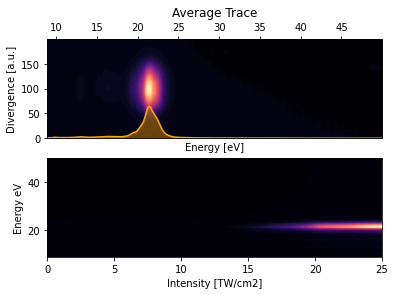

In [7]:
fig, ax = plt.subplots(2)
im, ax[0], ax2 = MCP100_Iris.plot_average(ax[0])
ax[0].set_title('Average Trace')
ax[0].xaxis.tick_top()
ax[0].set_xlabel('Energy [eV]', va = 'top')
ax[0].set_ylabel('Divergence [a.u.]')
im, ax[1] = MCP100_Iris.plot_scan_mean(ax[1], 'intensity')
ax[1].set_xlabel('Intensity [TW/cm2]')
ax[1].set_ylabel('Energy eV')
plt.show()

So from the average intensity scan we can only see the plasmon. We can see that the plasmon starts at around 12 TW/cm2. So we need to mask it at around 28 iris position. The plasmon analysis should be done at some point too. 

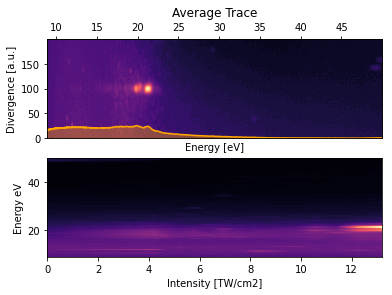

In [8]:
mask = MCP100_Iris.scan_data['iris']<=-26
MCP100_Iris.mask_data(mask)
fig, ax = plt.subplots(2)
im, ax[0], ax2 = MCP100_Iris.plot_average(ax[0])
ax[0].set_title('Average Trace')
ax[0].xaxis.tick_top()
ax[0].set_xlabel('Energy [eV]', va = 'top')
ax[0].set_ylabel('Divergence [a.u.]')
im, ax[1]= MCP100_Iris.plot_scan_mean(ax[1], 'intensity')
bad_trace = ax[1]
ax[1].set_xlabel('Intensity [TW/cm2]')
ax[1].set_ylabel('Energy eV')
plt.show()
MCP100_Iris.revert_mask()

The scatter seams constant throughout the Intensity scan so we can try to filter it out for out lineoutss - We need to check this is the same for all iris plots and all  samples and days!

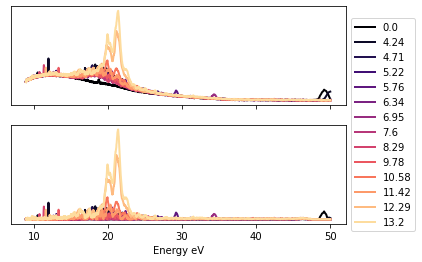

In [9]:

MCP100_Iris.mask_data(mask)
fig, ax = plt.subplots(2, sharex = True)
ax[0] = MCP100_Iris.plot_lineouts_mean_all(ax[0], stage)
MCP100_Iris.revert_mask()

MCP100_Iris.define_bump((None,2))
MCP100_Iris.mask_data(mask)

ax[1] = MCP100_Iris.plot_lineouts_mean_all(ax[1], stage)
ax[1].set_xlabel('Energy eV')
plt.legend(loc='center left', bbox_to_anchor=(1, 1))
plt.show()



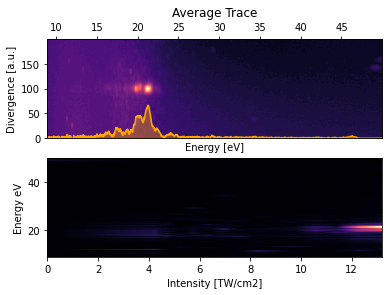

In [10]:

fig, ax = plt.subplots(2)
harm, ax[0], ax2 = MCP100_Iris.plot_average(ax[0])
ax[0].set_title('Average Trace')
ax[0].xaxis.tick_top()
ax[0].set_xlabel('Energy [eV]', va = 'top')
ax[0].set_ylabel('Divergence [a.u.]')
im, ax[1] = MCP100_Iris.plot_scan_mean(ax[1], 'intensity')
ax[1].set_xlabel('Intensity [TW/cm2]')
ax[1].set_ylabel('Energy eV')
plt.show()

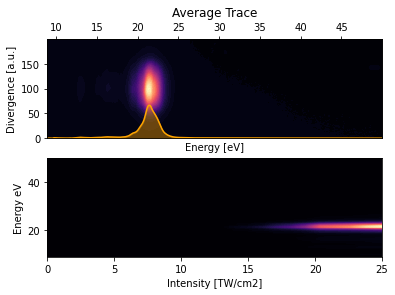

In [11]:
MCP100_Iris.revert_mask()

fig, ax = plt.subplots(2)
harm, ax[0], ax2 = MCP100_Iris.plot_average(ax[0])
ax[0].set_title('Average Trace')
ax[0].xaxis.tick_top()
ax[0].set_xlabel('Energy [eV]', va = 'top')
ax[0].set_ylabel('Divergence [a.u.]')
im, ax[1] = MCP100_Iris.plot_scan_mean(ax[1], 'intensity')
ax[1].set_xlabel('Intensity [TW/cm2]')
ax[1].set_ylabel('Energy eV')
plt.show()

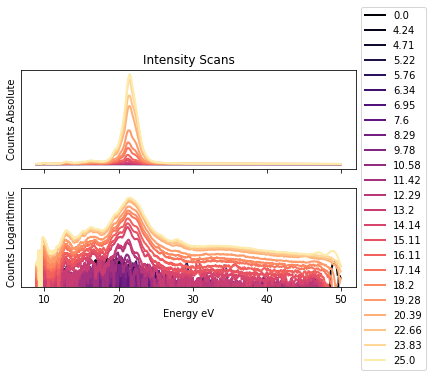

In [12]:
mask_low = MCP100_Iris.scan_data['intensity']>7
fig, ax = plt.subplots(2, sharex = True)
ax[0] = MCP100_Iris.plot_lineouts_mean_all(ax[0], stage)
ax[0].set_title('Intensity Scans')
ax[1] = MCP100_Iris.plot_lineouts_mean_all_log(ax[1], stage)
ax[1].set_xlabel('Energy eV')
ax[1].set_ylim(bottom=5)
ax[1].set_ylabel('Counts Logarithmic')
ax[0].set_ylabel('Counts Absolute')
plt.legend(loc='center left', bbox_to_anchor=(1, 1))
plt.show()
MCP100_Iris.revert_mask()

Obviously we would have to work on how to remove it from the traces a bit harder but I think we can for main analysis only look at the lineouts. There it seams to have unique improvement

## Repeating for other Iris scans
Iris_scan_SampleX-10_Y-5.25_Z9.0_rot_2_MgO_SWIR_MCP1200V_scanningUp_MCPpos70

In [13]:
MCP70_Iris = Scan()
MCP70_Iris.set_folder(MCP70_Up_Iris_Folder)
MCP70_Iris.set_verlim(100, 250)
files = [i for i in os.listdir(MCP70_Up_Iris_Folder)]
bg_files = ['-45_repeat1.tif', '-45_repeat2.tif']
exclude = bg_files + ['-22_repeat.tif']
files = [i for i in files if i not in exclude]
variables = [float(i[:-4]) for i in files]
MCP70_Iris.set_params(rotation=0, MCPPos=70000,wedge=1060)
MCP70_Iris.set_eVlim((12,25))
#stage = 'iris'

In [14]:
MCP70_Iris.populate_scan_manual(files, variables, stage='iris', function = Andor_calib)
MCP70_Iris.add_calibration_stage('intensity', iris_2801.get_intensity_TWcm2, 'iris')
stage = 'intensity'
MCP70_Iris.sort_by_stage(stage)

100%|██████████| 21/21 [00:08<00:00,  2.45it/s]


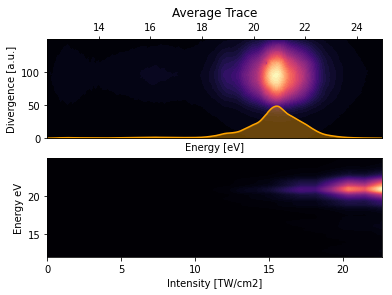

In [15]:
fig, ax = plt.subplots(2)
im, ax[0], ax2 = MCP70_Iris.plot_average(ax[0])
ax[0].set_title('Average Trace')
ax[0].xaxis.tick_top()
ax[0].set_xlabel('Energy [eV]', va = 'top')
ax[0].set_ylabel('Divergence [a.u.]')
im, ax[1] = MCP70_Iris.plot_scan_mean(ax[1], 'intensity')
ax[1].set_xlabel('Intensity [TW/cm2]')
ax[1].set_ylabel('Energy eV')
plt.show()

So from the average intensity scan we can only see the plasmon. We can see that the plasmon starts at around 12 TW/cm2. So we need to mask it at around 28 iris position. The plasmon analysis should be done at some point too. 

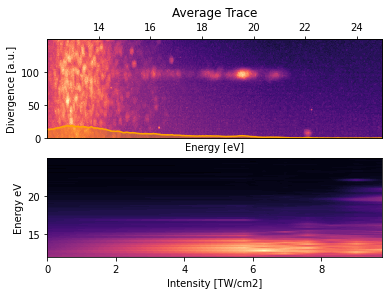

In [16]:
mask = MCP70_Iris.scan_data['iris']<=-28
MCP70_Iris.mask_data(mask)
fig, ax = plt.subplots(2)
im, ax[0], ax2 = MCP70_Iris.plot_average(ax[0])
ax[0].set_title('Average Trace')
ax[0].xaxis.tick_top()
ax[0].set_xlabel('Energy [eV]', va = 'top')
ax[0].set_ylabel('Divergence [a.u.]')
im, ax[1]= MCP70_Iris.plot_scan_mean(ax[1], 'intensity')
bad_trace = ax[1]
ax[1].set_xlabel('Intensity [TW/cm2]')
ax[1].set_ylabel('Energy eV')
plt.show()
MCP70_Iris.revert_mask()

The scatter seams constant throughout the Intensity scan so we can try to filter it out for out lineoutss - We need to check this is the same for all iris plots and all  samples and days!

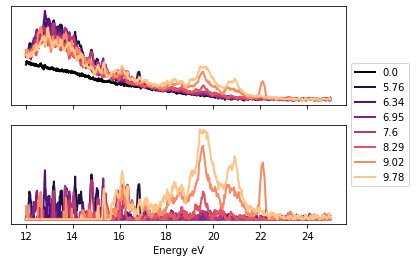

In [17]:
MCP70_Iris.reset_bump()
MCP70_Iris.mask_data(mask)
fig, ax = plt.subplots(2, sharex = True)
ax[0] = MCP70_Iris.plot_lineouts_mean_all(ax[0], stage)
MCP70_Iris.revert_mask()

MCP70_Iris.define_bump((1,4))
MCP70_Iris.mask_data(mask)

ax[1] = MCP70_Iris.plot_lineouts_mean_all(ax[1], stage)
ax[1].set_xlabel('Energy eV')
plt.legend(loc='center left', bbox_to_anchor=(1, 1))
plt.show()


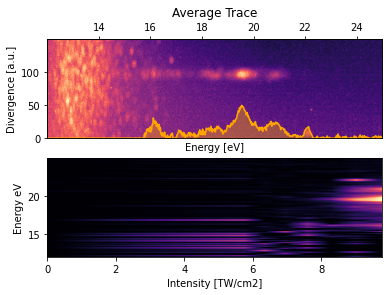

In [18]:
fig, ax = plt.subplots(2)
harm, ax[0], ax2 = MCP70_Iris.plot_average(ax[0])
ax[0].set_title('Average Trace')
ax[0].xaxis.tick_top()
ax[0].set_xlabel('Energy [eV]', va = 'top')
ax[0].set_ylabel('Divergence [a.u.]')
im, ax[1] = MCP70_Iris.plot_scan_mean(ax[1], 'intensity')
improved_trace = ax[1]
ax[1].set_xlabel('Intensity [TW/cm2]')
ax[1].set_ylabel('Energy eV')
plt.show()

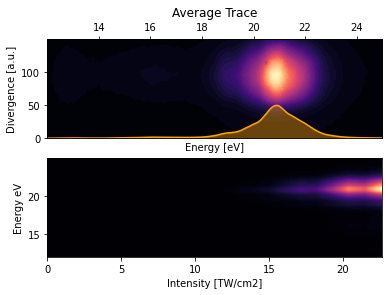

In [19]:

MCP70_Iris.revert_mask()
fig, ax = plt.subplots(2)
harm, ax[0], ax2 = MCP70_Iris.plot_average(ax[0])
ax[0].set_title('Average Trace')
ax[0].xaxis.tick_top()
ax[0].set_xlabel('Energy [eV]', va = 'top')
ax[0].set_ylabel('Divergence [a.u.]')
im, ax[1] = MCP70_Iris.plot_scan_mean(ax[1], 'intensity')
improved_trace = ax[1]
ax[1].set_xlabel('Intensity [TW/cm2]')
ax[1].set_ylabel('Energy eV')
plt.show()

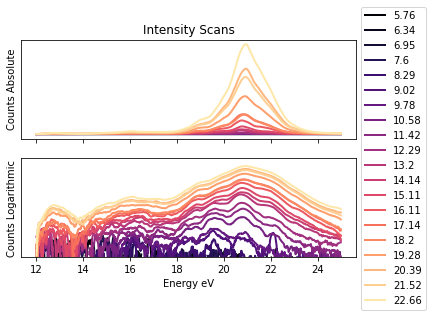

In [20]:
mask_low = MCP70_Iris.scan_data['intensity']>2

MCP70_Iris.mask_data(mask_low)
fig, ax = plt.subplots(2, sharex = True)
ax[0] = MCP70_Iris.plot_lineouts_mean_all(ax[0], stage)
ax[0].set_title('Intensity Scans')
ax[1] = MCP70_Iris.plot_lineouts_mean_all_log(ax[1], stage)
ax[1].set_xlabel('Energy eV')
ax[1].set_ylim(bottom=5)
ax[1].set_ylabel('Counts Logarithmic')
ax[0].set_ylabel('Counts Absolute')
plt.legend(loc='center left', bbox_to_anchor=(1, 1))
plt.show()
MCP70_Iris.revert_mask()

## scanning down

2022-01-28/Iris_scan_SampleX-10_Y-5.25_Z6.8_rot_2_MgO_SWIRMCP1200V_scanningDown_MCPpos70

In [38]:
MCP70_Iris_Down = Scan()
MCP70_Iris_Down.set_folder(MCP70_Down_Iris_Folder)
MCP70_Iris_Down.set_verlim(100, 250)
files = [i for i in os.listdir(MCP70_Down_Iris_Folder)]
bg_files = []
exclude = bg_files + ['-29_120secexp.tif', '-30_120secexp.tif']
files = [i for i in files if i not in exclude]
variables = [float(i[:-4]) for i in files]
MCP70_Iris_Down.set_params(rotation=0, MCPPos=70000,wedge=1060)
MCP70_Iris_Down.set_eVlim((12,25))


In [39]:
MCP70_Iris_Down.populate_scan_manual(files, variables, stage='iris', function = Andor_calib)
MCP70_Iris_Down.add_calibration_stage('intensity', iris_2801.get_intensity_TWcm2, 'iris')
stage = 'intensity'
MCP70_Iris_Down.sort_by_stage(stage)

100%|██████████| 18/18 [00:08<00:00,  2.19it/s]


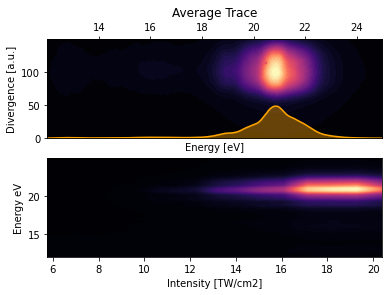

In [40]:
fig, ax = plt.subplots(2)
im, ax[0], ax2 = MCP70_Iris_Down.plot_average(ax[0])
ax[0].set_title('Average Trace')
ax[0].xaxis.tick_top()
ax[0].set_xlabel('Energy [eV]', va = 'top')
ax[0].set_ylabel('Divergence [a.u.]')
im, ax[1] = MCP70_Iris_Down.plot_scan_mean(ax[1], 'intensity')
ax[1].set_xlabel('Intensity [TW/cm2]')
ax[1].set_ylabel('Energy eV')
plt.show()

So from the average intensity scan we can only see the plasmon. We can see that the plasmon starts at around 12 TW/cm2. So we need to mask it at around 28 iris position. The plasmon analysis should be done at some point too. 

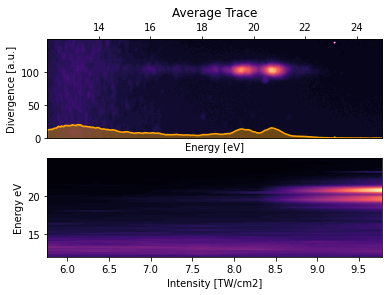

In [41]:
mask = MCP70_Iris_Down.scan_data['iris']<=-28
MCP70_Iris_Down.mask_data(mask)
fig, ax = plt.subplots(2)
im, ax[0], ax2 = MCP70_Iris_Down.plot_average(ax[0])
ax[0].set_title('Average Trace')
ax[0].xaxis.tick_top()
ax[0].set_xlabel('Energy [eV]', va = 'top')
ax[0].set_ylabel('Divergence [a.u.]')
im, ax[1]= MCP70_Iris_Down.plot_scan_mean(ax[1], 'intensity')
bad_trace = ax[1]
ax[1].set_xlabel('Intensity [TW/cm2]')
ax[1].set_ylabel('Energy eV')
plt.show()
MCP70_Iris_Down.revert_mask()

The scatter seams constant throughout the Intensity scan so we can try to filter it out for out lineoutss - We need to check this is the same for all iris plots and all  samples and days!

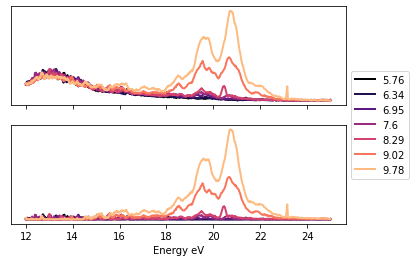

In [42]:
MCP70_Iris_Down.reset_bump()
MCP70_Iris_Down.mask_data(mask)
fig, ax = plt.subplots(2, sharex = True)
ax[0] = MCP70_Iris_Down.plot_lineouts_mean_all(ax[0], stage)
MCP70_Iris_Down.revert_mask()

MCP70_Iris_Down.define_bump((None,4))
MCP70_Iris_Down.mask_data(mask)

ax[1] = MCP70_Iris_Down.plot_lineouts_mean_all(ax[1], stage)
ax[1].set_xlabel('Energy eV')
plt.legend(loc='center left', bbox_to_anchor=(1, 1))
plt.show()


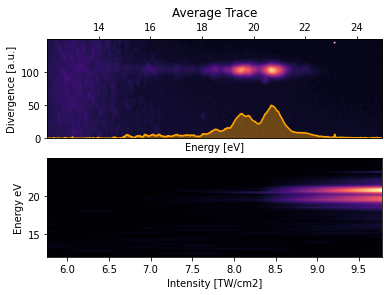

In [43]:
fig, ax = plt.subplots(2)
harm, ax[0], ax2 = MCP70_Iris_Down.plot_average(ax[0])
ax[0].set_title('Average Trace')
ax[0].xaxis.tick_top()
ax[0].set_xlabel('Energy [eV]', va = 'top')
ax[0].set_ylabel('Divergence [a.u.]')
im, ax[1] = MCP70_Iris_Down.plot_scan_mean(ax[1], 'intensity')
ax[1].set_xlabel('Intensity [TW/cm2]')
ax[1].set_ylabel('Energy eV')
plt.show()

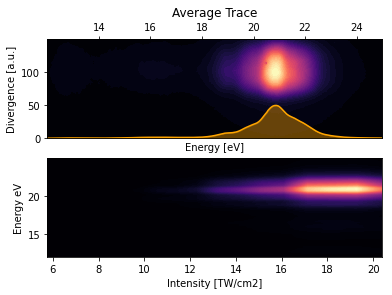

In [44]:

MCP70_Iris_Down.revert_mask()
fig, ax = plt.subplots(2)
harm, ax[0], ax2 = MCP70_Iris_Down.plot_average(ax[0])
ax[0].set_title('Average Trace')
ax[0].xaxis.tick_top()
ax[0].set_xlabel('Energy [eV]', va = 'top')
ax[0].set_ylabel('Divergence [a.u.]')
im, ax[1] = MCP70_Iris_Down.plot_scan_mean(ax[1], 'intensity')
ax[1].set_xlabel('Intensity [TW/cm2]')
ax[1].set_ylabel('Energy eV')
plt.show()

KeyError: 0

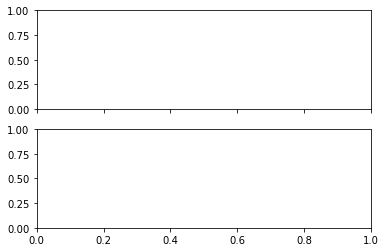

In [48]:
mask_low = MCP70_Iris_Down.scan_data['intensity']>0

MCP70_Iris_Down.mask_data(mask_low)
fig, ax = plt.subplots(2, sharex = True)
ax[0] = MCP70_Iris_Down.plot_lineouts_mean_all(ax[0], stage)
ax[0].set_title('Intensity Scans')
ax[1] = MCP70_Iris_Down.plot_lineouts_mean_all_log(ax[1], stage)
ax[1].set_xlabel('Energy eV')
ax[1].set_ylim(bottom=1)
ax[1].set_ylabel('Counts Logarithmic')
ax[0].set_ylabel('Counts Absolute')
plt.legend(loc='center left', bbox_to_anchor=(1, 1))
plt.show()
MCP70_Iris_Down.revert_mask()

In [31]:
x, y, Z = MCP70_Iris_Down.return_scan_data(stage='intensity')


In [32]:
Z.shape

(18, 765)

In [33]:
y_mask = (y<16)
Z_highE = Z[:,y_mask]

In [34]:
peak = Z_highE.max(axis=1)

In [35]:
peak.shape

(18,)

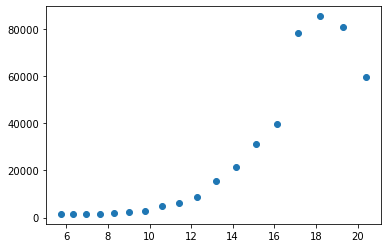

In [36]:
plt.scatter(x, peak)